# Pre-processing and data augmentation for computer vision

The goal of this notebook is to dicuss pre-processing and data augmentation for computer vission problems.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random

In [20]:
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Cats and dogs data for pre-trained networks

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle competitions download -d  dogs-vs-cats -p PATH` <br/>

You can also get the data from fast.ai <br/>
`wget http://files.fast.ai/data/dogscats.zip`

In [3]:
PATH = Path("/data2/yinterian/dogscats/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/dogscats/model.pth'),
 PosixPath('/data2/yinterian/dogscats/mode_tmp.pth'),
 PosixPath('/data2/yinterian/dogscats/valid'),
 PosixPath('/data2/yinterian/dogscats/test1'),
 PosixPath('/data2/yinterian/dogscats/sample'),
 PosixPath('/data2/yinterian/dogscats/train'),
 PosixPath('/data2/yinterian/dogscats/models')]

In [4]:
! ls /data2/yinterian/dogscats/train

cats  dogs


In [5]:
! ls /data2/yinterian/dogscats/train/cats | head

cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
cat.10004.jpg
cat.10005.jpg
cat.10006.jpg
cat.10007.jpg
cat.10008.jpg
ls: write error: Broken pipe


In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(359, 431, 3)


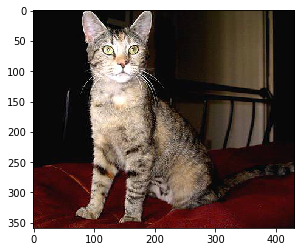

In [7]:
path = PATH/"train/cats/cat.10000.jpg"
im = read_image(path)
plt.imshow(im)
print(im.shape)

In [8]:
# let's look at the typical size of these images
path = PATH/"train/cats"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(411, 500, 3),
 (374, 500, 3),
 (374, 500, 3),
 (479, 400, 3),
 (349, 400, 3),
 (374, 498, 3),
 (374, 500, 3),
 (431, 288, 3),
 (317, 336, 3),
 (399, 310, 3)]

### Data augmentation for cats and dogs
Data augmentation is the most important way to avoid overfitting for image classification tasks. <br>
In this example, the cats are mostly in the middle of the image therefore doing center cropping is fine.

In [9]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

(359, 359, 3)


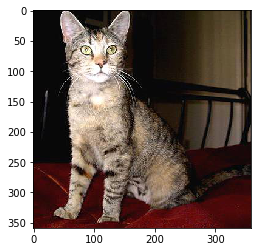

In [10]:
path = PATH/"train/cats/cat.10000.jpg"
im = read_image(path)
im = center_crop(im)
plt.imshow(im)
print(im.shape)

### Resize, horizontal and vertical translations

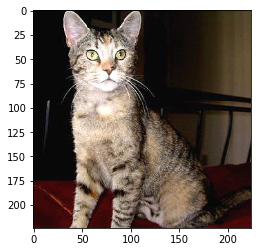

In [11]:
# resize desforms the image a bit
# By resizing to a larger number and random cropping we are doing horizontal and 
# vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (250, 250))
im2 = random_crop(im, 224, 224)
plt.imshow(im2)

### Random Rotation (-10, 10) 

-7.096396818952602


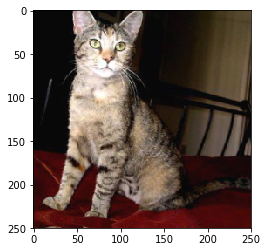

In [12]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

### Horizontal Flip

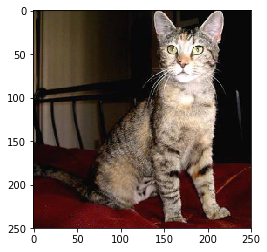

In [13]:
im_f = np.fliplr(im)
plt.imshow(im_f)

###  np.rollaxis

In [14]:
# pytorch expects channels to go first
im_roll = np.rollaxis(im, 2)
print(im.shape)
print(im_roll.shape)

(250, 250, 3)
(3, 250, 250)


### Dogs and cats Dataset

In [15]:
# When using pre-trained networks you should normalized your images in the same way the
# authors of the model did.
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [16]:
class DogsCatsDataset(Dataset):
    def __init__(self, PATH, train="train", transforms=False, sz=224):
        self.path_to_images = PATH/train
        self.transforms = transforms
        self.sz = sz
        self.sz2 = int(sz*1.05)
        self.cats_files = list((self.path_to_images/"cats").iterdir())
        self.dogs_files = list((self.path_to_images/"dogs").iterdir())
        self.files = self.cats_files + self.dogs_files
        # cats 1, dogs, 0
        self.y = np.concatenate((np.ones(len(self.cats_files), dtype=int),
                                np.zeros(len(self.dogs_files), dtype=int)), axis=0)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        path = str(self.files[idx])
        # scaling
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        # center crop
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        # substract numbers from resnet34
        x = normalize(x)
        return np.rollaxis(x, 2), self.y[idx]

In [17]:
# train should be transformed, validation should not be transformed
train_ds = DogsCatsDataset(PATH, "train", transforms=True)
valid_ds = DogsCatsDataset(PATH, "valid")

## Exercise: other augmentations

Download any image and play with other augmentations. Take a look at fast.ai transforms [here](https://github.com/fastai/fastai/blob/master/fastai/transforms.py) and borrow code for any of these transforms: changes lighting, random scale (RandomScale), cutout (cut random holes), RandomBlur. Show an example on how it works on an image.

## Back and white images -- training from scratch  

For this part of the notebook we will use the bone age dataset. The task here is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. 

### Data

To get the data you can install the kaggle api using: 
`pip install kaggle`
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ ) <br>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH`

In [20]:
PATH = Path("/data2/yinterian/rsna-bone-age/")
#list(PATH.iterdir())

In [21]:
! head /data2/yinterian/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


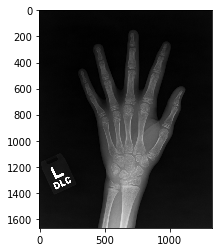

In [22]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

### Saving a resized dataset
These images range in size and aspect ratio. They are also larger than you need for training. Loading each image may take extra time at training. Let's pre-process the data before we start training.

In [23]:
# make a new dir for images
PATH_550 = PATH/"boneage-550"
#PATH_550.mkdir()

In [24]:
# in order to take a center crop without cutting much or the hand
# I am adding some reflective border to the shorter side.
# This works in these images because borders are mostly black
def get_a_crop(path, sz=550):
    im = cv2.imread(str(path))
    r,c,_ = im.shape
    pad = abs(r-c)//4
    if r > c :
        im2 = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_REFLECT)
    else:
        im2 = cv2.copyMakeBorder(im, pad, pad, 0, 0, cv2.BORDER_REFLECT)
    return cv2.resize(center_crop(im2), (sz, sz))

In [25]:
im2 = get_a_crop(path)

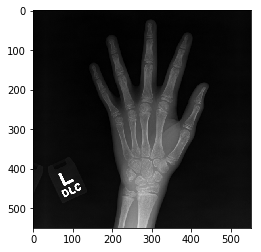

In [26]:
# note the reflective border
plt.imshow(im2, cmap='gray')

In [27]:
from os import listdir
from os.path import join
def resize_all_images(sz):
    for f in listdir(PATH/"boneage-training-dataset/"):
        old_path = join(PATH/"boneage-training-dataset/", f)
        new_path = join(PATH/"boneage-550/", f)
        img2 = get_a_crop(old_path,sz)
        cv2.imwrite(new_path, img2)

In [28]:
#resize_all_images(sz)

In [29]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, transforms=True, sz=400):
        self.path_to_images = PATH/"boneage-550/"
        self.transforms = transforms
        self.df = df
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x = cv2.imread(str(path)).astype(np.float32)/255
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        # since black and white I return a 2D image
        x = x[:,:,0]
        return x[None], y # getting the right shape

## Bounding boxes and Y transforms
In some problems if you transform the image the $y$ should be transformed as well. The data for this part comes from the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring). The competition asks you to detect which species of fish appears on a fishing boat, based on images captured from boat cameras of various angles. One of the competitors hand labeled bounding box data. Here is how the data looks like:

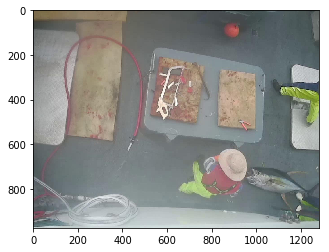

In [30]:
path = "/home/yinterian/img_02642.jpg"
im = read_image(path) 
plt.imshow(im)

In [31]:
bb = np.array([699.399, 954.697, 895.326, 1275.3])

In [32]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

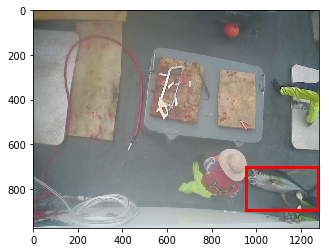

In [33]:
show_corner_bb(im, bb)

### Transforming Y

Suppose that your task is to predict the bounding box for the fish. If that is the case for image augmentation you also need to trasform the bounding box. One strategy is to transform the bounding box to a 2D image of the same dimension of X and treat the bounding box as points in that image. Let's implement some of these transforms.

In [35]:
# These helper functions transforms to and from bounding boxes

def coords2px(y, x):
    """ Transforming bounding boxes to pixels"""
    rows = np.rint([y[0], y[0], y[2], y[2]]).astype(int)
    cols = np.rint([y[1], y[3], y[1], y[3]]).astype(int)
    r,c,*_ = x.shape
    Y = np.zeros((r, c))
    Y[rows, cols] = 1
    return Y

def make_bb_px(y, x):
    """ Makes an image of size x retangular bounding box"""
    r,c,*_ = x.shape
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y

def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [36]:
Y = coords2px(bb, im)
print(Y.shape)
print(im.shape)

(974, 1280)
(974, 1280, 3)


In [37]:
print(bb)
to_bb(Y)

[ 699.399  954.697  895.326 1275.3  ]


array([ 699.,  955.,  895., 1275.], dtype=float32)

In [38]:
Y = make_bb_px(bb, im)
to_bb(Y)

array([ 699.,  954.,  894., 1274.], dtype=float32)

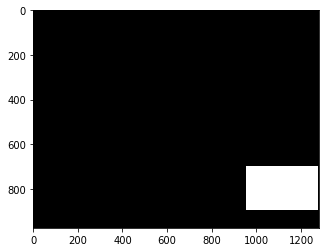

In [39]:
plt.imshow(Y, cmap='gray')

### Resize

In [40]:
def resize_tr(im, bb, sz):
    Y = make_bb_px(bb, im)
    im2 = cv2.resize(im, (sz, sz))
    Y2 = cv2.resize(Y, (sz, sz))
    return im2, to_bb(Y2)

In [41]:
im2, bb2 = resize_tr(im, bb, 224)
bb2

array([161., 167., 205., 222.], dtype=float32)

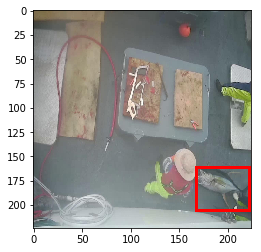

In [42]:
show_corner_bb(im2, bb2)

### Rotate
To get this to work well we have to re-write rotate.

In [67]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [60]:
def rotate_tr(im, bb, deg):
    rdeg = 2*(np.random.random()-.50)*deg
    print(rdeg)
    Y = make_bb_px(bb, im)
    im_rot = rotate_cv(im, rdeg)
    Y_rot = rotate_cv(Y, rdeg, y=True)
    return im_rot, to_bb(Y_rot)   

In [65]:
im2, bb2 = rotate_tr(im, bb, 20)
bb2

7.981344097121501


array([ 611.,  980.,  847., 1279.], dtype=float32)

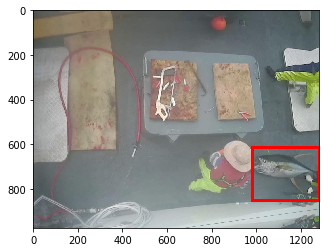

In [66]:
show_corner_bb(im2, bb2)

## Random Flip
Write this one

### Exercise:
Make a dataset for this problem.

## Image segmentation